In [1]:
# =============================================
#   CellMap nucleus-related segmentation (crop292 only)
#   Classes: 20,21,22,23,24,28
#   Author: Chenle Wang
#   TU Dresden - CMS Research Project
# =============================================

import os
import json
import numpy as np
import zarr 
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter, sobel, laplace
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, f1_score
from sklearn.model_selection import KFold # type: ignore

In [12]:
# ============================================================
# Step 1. Setup paths
# ============================================================

RAW_S0 = r"../data/jrc_cos7-1a/jrc_cos7-1a.zarr/recon-1/em/fibsem-uint8/s0"
CROP292_ROOT = r"../data/jrc_cos7-1a/jrc_cos7-1a.zarr/recon-1/labels/groundtruth/crop292"

# === Selected 5 classes: mito_mem(3), mito_lum(4), hchrom(24), nucpl(28), cyto(35) ===
TRAIN_CLASSES_SOURCE = {
    "mito_mem": 3,
    "mito_lum": 4,
    "hchrom": 24,
    "nucpl": 28,
    "cyto": 35,
}

# Remap to 1–5
CLASS_ID_MAP = {
    "mito_mem": 1,
    "mito_lum": 2,
    "hchrom": 3,
    "nucpl": 4,
    "cyto": 5,
}

CLASS_LIST = list(CLASS_ID_MAP.keys())
CLASS_EVAL_IDS = [1, 2, 3, 4, 5]

# Use nucpl as reference crop
REF_CLASS = "nucpl"
REF_S0 = os.path.join(CROP292_ROOT, REF_CLASS, "s0")
REF_ZATTR = os.path.join(CROP292_ROOT, REF_CLASS, ".zattrs")

# Load raw & reference
raw_zarr = zarr.open(RAW_S0, mode="r")
ref_zarr = zarr.open(REF_S0, mode="r")

print("Raw shape:", raw_zarr.shape)
print("Reference label shape:", ref_zarr.shape)

Raw shape: (1813, 4368, 20609)
Reference label shape: (400, 400, 400)


In [13]:
# ============================================================
# Step 2. Read .zattrs
# ============================================================

with open(REF_ZATTR, "r") as f:
    attrs = json.load(f)

ms = attrs["multiscales"][0]["datasets"][0]
scale = ms["coordinateTransformations"][0]["scale"]
trans = ms["coordinateTransformations"][1]["translation"]

scale_z, scale_y, scale_x = scale
tz, ty, tx = trans

print("Scale:", scale)
print("Translation:", trans)

Scale: [2.0, 2.0, 2.0]
Translation: [862.0, 5282.0, 6702.0]


In [14]:
# ============================================================
# Step 3. Compute voxel crop
# ============================================================

vz0 = int(tz / scale_z)
vy0 = int(ty / scale_y)
vx0 = int(tx / scale_x)

Dz, Dy, Dx = ref_zarr.shape
vz1, vy1, vx1 = vz0 + Dz, vy0 + Dy, vx0 + Dx

print("Voxel coords:", (vz0, vz1), (vy0, vy1), (vx0, vx1))

raw_crop = raw_zarr[vz0:vz1, vy0:vy1, vx0:vx1]
print("Raw crop shape:", raw_crop.shape)

Voxel coords: (431, 831) (2641, 3041) (3351, 3751)
Raw crop shape: (400, 400, 400)



===== Loading selected 5-class labels =====
mito_mem -> class 1, unique=[0 1]
mito_lum -> class 2, unique=[0 1]
hchrom   -> class 3, unique=[0 1]
nucpl    -> class 4, unique=[0 1]
cyto     -> class 5, unique=[0 1]
Unique classes in final label: [0 1 2 3 4 5]


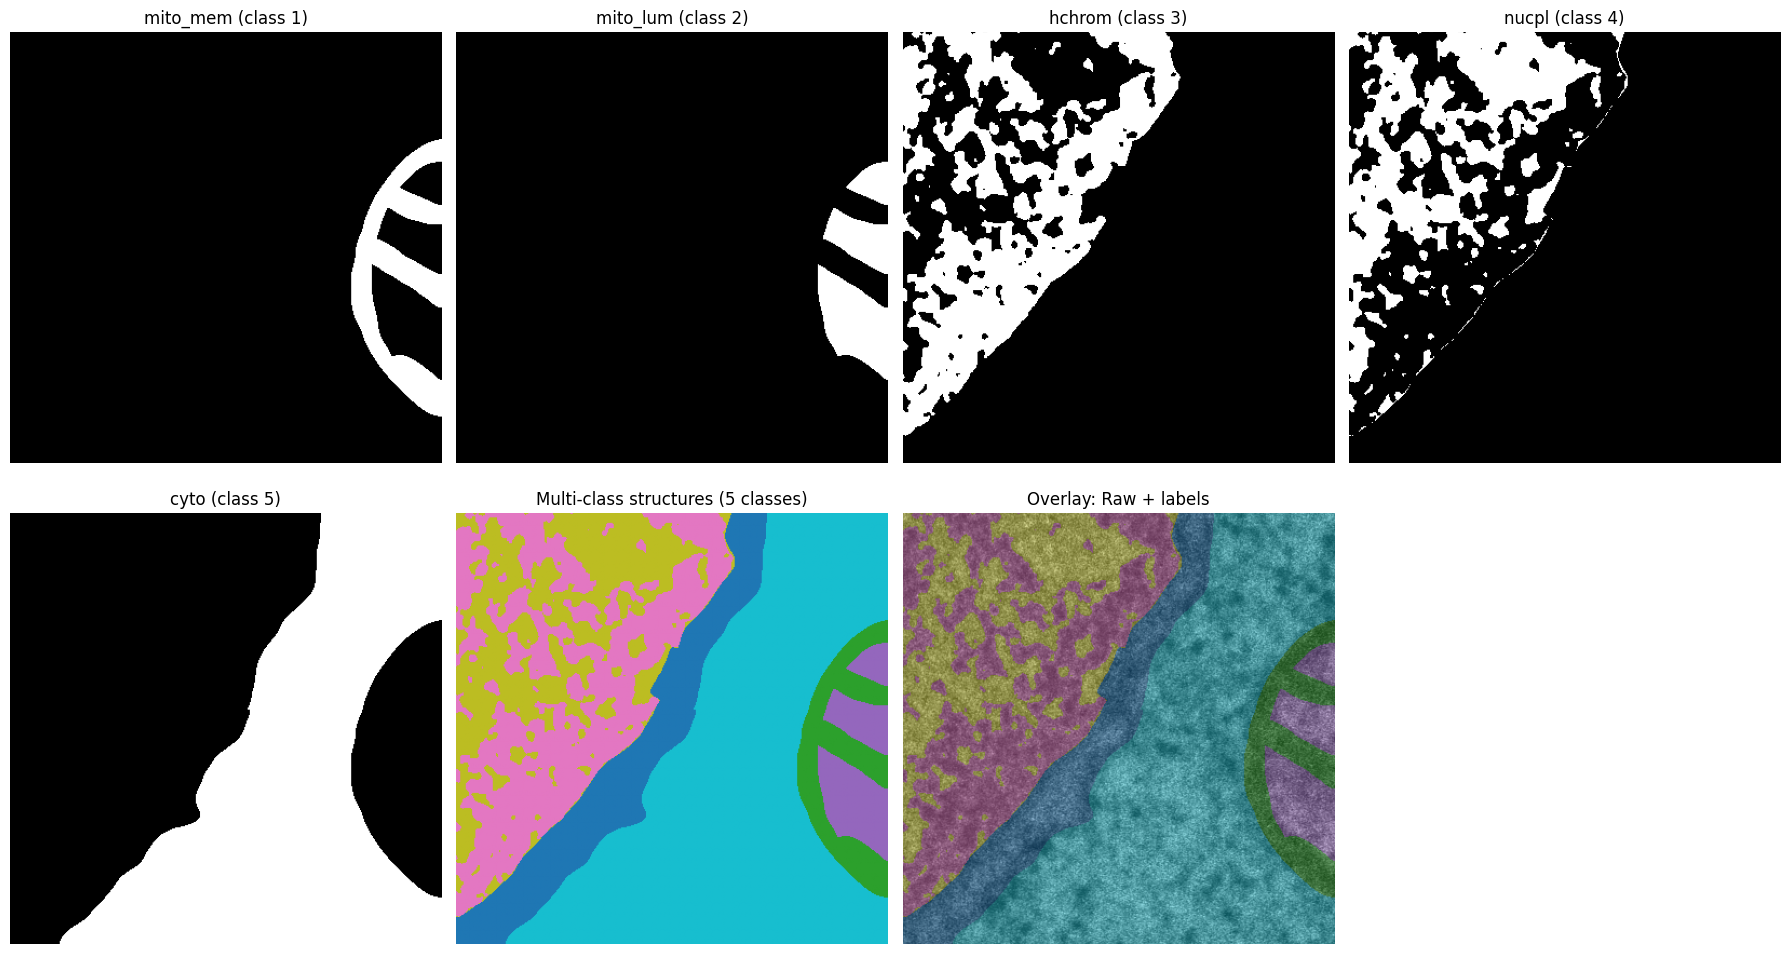

In [18]:
# ============================================================
# Step 4. Build 5-class GT mask
# ============================================================

label_multi = np.zeros(ref_zarr.shape, dtype=np.uint8)

print("\n===== Loading selected 5-class labels =====")
for cname, src_id in TRAIN_CLASSES_SOURCE.items():
    path = os.path.join(CROP292_ROOT, cname, "s0")
    arr = zarr.open(path, mode="r")[:]
    new_id = CLASS_ID_MAP[cname]
    print(f"{cname:8s} -> class {new_id}, unique={np.unique(arr)}")
    label_multi[arr > 0] = new_id

print("Unique classes in final label:", np.unique(label_multi))
mid = label_multi.shape[0] // 10

plt.figure(figsize=(18, 10))

# 逐类单独可视化（5 类）
for i, cname in enumerate(CLASS_LIST):
    cid = CLASS_ID_MAP[cname]
    mask = (label_multi[mid] == cid)

    plt.subplot(2, 4, i + 1)
    plt.imshow(mask, cmap="gray")
    plt.title(f"{cname} (class {cid})")
    plt.axis("off")

# 多类别总览图（彩色）
plt.subplot(2, 4, 6)
plt.imshow(label_multi[mid], cmap="tab10")
plt.title("Multi-class structures (5 classes)")
plt.axis("off")

# 叠加图（raw + label）
plt.subplot(2, 4, 7)
plt.imshow(raw_crop[mid], cmap='gray')
plt.imshow(label_multi[mid], cmap='tab10', alpha=0.45)
plt.title("Overlay: Raw + labels")
plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
# ============================================================
# Step 5 (Modified): 3D Feature Extraction
# 三维特征提取：对每个 z-slice 提取前后层的空间信息
# ============================================================
def extract_3d_features(volume, z):
    """
    volume: 3D EM volume (Z,Y,X)
    z: target slice index

    return: (Y,X,C) feature map | C=3 (raw, gaussian, sobel_mag)
    """

    # -------- 1) raw slice --------
    raw_ = volume[z]

    # -------- 2) 3D Gaussian (sigma=1) --------
    g1 = gaussian_filter(volume, sigma=1)[z]

    # -------- 3) 3D Sobel magnitude --------
    sob_z = sobel(volume, axis=0)[z]
    sob_y = sobel(volume, axis=1)[z]
    sob_x = sobel(volume, axis=2)[z]
    sob_mag = np.sqrt(sob_x**2 + sob_y**2 + sob_z**2)

    # -------- stack 3 feature channels --------
    feat = np.stack([raw_, g1, sob_mag], axis=-1)  # shape (Y,X,3)

    return feat

In [7]:
# ============================================================
# Step 5.1: Build features for SELECTED z-slices only
# 为 n 个 z 层生成 3D 特征（快速实验模式）
# ============================================================

Z = raw_crop.shape[0]
selected_z = np.arange(Z)   # use the entire crop

print("Selected z-slices:", selected_z)

# Allocate lists with fixed length = Z
X_slices = [None] * Z
y_slices = [None] * Z

# Build 3D features for every z-slice
for i, z in enumerate(selected_z):
    feat = extract_3d_features(raw_crop, z)  # (Y,X,3)
    lab  = label_multi[z]                   # (Y,X)

    # Flatten per-slice for RF training
    X_slices[i] = feat.reshape(-1, feat.shape[-1])
    y_slices[i] = lab.reshape(-1)


Selected z-slices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241

KeyboardInterrupt: 

In [11]:
# ============================================================
# Step 6: K-fold Cross Validation (按 z 层划分)
# ============================================================

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_scores = []


: 

In [ ]:
# ============================================================
# Step 7: Train & Validate (selected_z only) — 5-class version
# ============================================================

import time
from tqdm import tqdm
from sklearn.metrics import jaccard_score, f1_score

fold_scores = []

# 只评估 5 个选中的类（1–5）
labels_eval = CLASS_EVAL_IDS     # [1,2,3,4,5]
class_names = CLASS_LIST         # ["mito_mem","mito_lum","hchrom","nucpl","cyto"]

# Outer progress bar for K-fold
for fold, (train_idx, val_idx) in tqdm(
    enumerate(kf.split(range(len(selected_z)))),
    total=kf.n_splits,
    desc="K-Fold Progress"
):

    print(f"\n================ FOLD {fold} ================")
    fold_start = time.time()

    # Build slice index lists
    train_z = [selected_z[i] for i in train_idx]
    val_z   = [selected_z[i] for i in val_idx]

    print("Train z slices:", train_z)
    print("Valid z slices:", val_z)

    # Inner progress bar (4 steps)
    fold_bar = tqdm(total=4, desc=f"Fold {fold} steps", leave=False)

    # ============================================================
    # Step A: Build training set
    # ============================================================
    fold_bar.set_postfix_str("Building train set")
    X_train = np.concatenate([X_slices[z] for z in train_z])
    y_train = np.concatenate([y_slices[z] for z in train_z])
    fold_bar.update(1)

    # ============================================================
    # Step B: Build validation set
    # ============================================================
    fold_bar.set_postfix_str("Building val set")
    X_val = np.concatenate([X_slices[z] for z in val_z])
    y_val = np.concatenate([y_slices[z] for z in val_z])
    fold_bar.update(1)

    print("Train size:", X_train.shape)
    print("Val size:  ", X_val.shape)

    # ============================================================
    # Step C: Train RandomForest
    # ============================================================
    fold_bar.set_postfix_str("Training RandomForest (may take minutes...)")
    clf = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_train, y_train)
    fold_bar.update(1)

    # ============================================================
    # Step D: Predict validation set
    # ============================================================
    fold_bar.set_postfix_str("Predicting on val set")
    y_pred = clf.predict(X_val)
    fold_bar.update(1)
    fold_bar.close()

    # ============================================================
    # Step E: Compute evaluation metrics for 5 classes
    # ============================================================

    # Macro IoU & Dice only on the 5 classes
    iou_macro = jaccard_score(y_val, y_pred, average="macro", labels=labels_eval)
    dice_macro = f1_score(y_val, y_pred, average="macro", labels=labels_eval)

    print(f"FOLD {fold}  IoU_macro={iou_macro:.4f}   Dice_macro={dice_macro:.4f}")

    # Per-class IoU
    per_class_iou = jaccard_score(
        y_val, y_pred,
        average=None,
        labels=labels_eval
    )

    print("\nPer-class IoU:")
    for cname, cid, ciou in zip(class_names, labels_eval, per_class_iou):
        print(f"  Class {cid:2d} ({cname:8s}) IoU = {ciou:.4f}")

    # Fold time
    elapsed = time.time() - fold_start
    print(f"⏱ Fold {fold} took {elapsed/60:.2f} minutes\n")

    fold_scores.append((iou_macro, dice_macro))


K-Fold Progress:   0%|          | 0/5 [00:00<?, ?it/s]


================ FOLD 0 ================
Train z slices: [np.int64(0), np.int64(8), np.int64(16), np.int64(24), np.int64(32), np.int64(40), np.int64(48), np.int64(57), np.int64(65), np.int64(73), np.int64(81), np.int64(89), np.int64(97), np.int64(114), np.int64(122), np.int64(130), np.int64(146), np.int64(162), np.int64(171), np.int64(179), np.int64(187), np.int64(195), np.int64(219), np.int64(228), np.int64(236), np.int64(252), np.int64(268), np.int64(276), np.int64(285), np.int64(293), np.int64(301), np.int64(309), np.int64(325), np.int64(333), np.int64(342), np.int64(350), np.int64(358), np.int64(374), np.int64(382), np.int64(399)]
Valid z slices: [np.int64(105), np.int64(138), np.int64(154), np.int64(203), np.int64(211), np.int64(244), np.int64(260), np.int64(317), np.int64(366), np.int64(390)]


Train size: (6400000, 4)
Val size:   (1600000, 4)


In [16]:
# ============================================================
# Step 8: Print final aggregated results
# ============================================================
print("\n================ Final K-fold Results ================\n")

for k, (iou, dice) in enumerate(fold_scores):
    print(f"Fold {k}:   IoU={iou:.4f}   Dice={dice:.4f}")

avg_iou  = np.mean([s[0] for s in fold_scores])
avg_dice = np.mean([s[1] for s in fold_scores])

print("\nAverage IoU :", avg_iou)
print("Average Dice:", avg_dice)


================ Final K-fold Results ================

Fold 0:   IoU=0.1999   Dice=0.2578
Fold 1:   IoU=0.1777   Dice=0.2434
Fold 2:   IoU=0.1888   Dice=0.2538
Fold 3:   IoU=0.1886   Dice=0.2505
Fold 4:   IoU=0.1913   Dice=0.2540

Average IoU : 0.18924702879724345
Average Dice: 0.2519024784852161


In [38]:
# ============================================================
# Step 7: Train & Validate (selected_z only)
# ============================================================

for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(selected_z)))):
    train_z = [selected_z[i] for i in train_idx]
    val_z = [selected_z[i] for i in val_idx]

    print(f"\n================ FOLD {fold} ================")
    print("Train z slices:", train_z)
    print("Valid z slices:", val_z)

    X_train = np.concatenate([X_slices[z] for z in train_z])
    y_train = np.concatenate([y_slices[z] for z in train_z])

    X_val = np.concatenate([X_slices[z] for z in val_z])
    y_val = np.concatenate([y_slices[z] for z in val_z])


    print("Train size:", X_train.shape)
    print("Val   size:", X_val.shape)

    clf = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        n_jobs=8,
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    iou = jaccard_score(y_val, y_pred, average="macro")
    dice = f1_score(y_val, y_pred, average="macro")

    print(f"FOLD {fold}  IoU={iou:.4f}  Dice={dice:.4f}")
    fold_scores.append((iou, dice))



================ FOLD 0 ================
Train z slices: [np.int64(0), np.int64(13), np.int64(27), np.int64(41), np.int64(55), np.int64(68), np.int64(82), np.int64(96), np.int64(137), np.int64(151), np.int64(165), np.int64(178), np.int64(192), np.int64(220), np.int64(247), np.int64(261), np.int64(275), np.int64(288), np.int64(302), np.int64(330), np.int64(343), np.int64(357), np.int64(385), np.int64(399)]
Valid z slices: [np.int64(110), np.int64(123), np.int64(206), np.int64(233), np.int64(316), np.int64(371)]
Train size: (3840000, 4)
Val   size: (960000, 4)
FOLD 0  IoU=0.1990  Dice=0.2532

================ FOLD 1 ================
Train z slices: [np.int64(13), np.int64(27), np.int64(41), np.int64(68), np.int64(82), np.int64(96), np.int64(110), np.int64(123), np.int64(137), np.int64(151), np.int64(178), np.int64(192), np.int64(206), np.int64(233), np.int64(247), np.int64(261), np.int64(275), np.int64(288), np.int64(302), np.int64(316), np.int64(343), np.int64(357), np.int64(371), np.i

In [25]:
# ============================================================
# Step 8: Print Final Results
# ============================================================

print("\n================ Final K-fold Results ================\n")

for k, (iou, dice) in enumerate(fold_scores):
    print(f"Fold {k}:   IoU={iou:.4f}   Dice={dice:.4f}")

avg_iou = np.mean([s[0] for s in fold_scores])
avg_dice = np.mean([s[1] for s in fold_scores])

print("\nAverage IoU :", avg_iou)
print("Average Dice:", avg_dice)



================ Final K-fold Results ================

Fold 0:   IoU=0.1890   Dice=0.2466
Fold 1:   IoU=0.1657   Dice=0.2317
Fold 2:   IoU=0.1967   Dice=0.2507
Fold 3:   IoU=0.2112   Dice=0.2566
Fold 4:   IoU=0.1984   Dice=0.2505

Average IoU : 0.1921901364119316
Average Dice: 0.2472358430836002


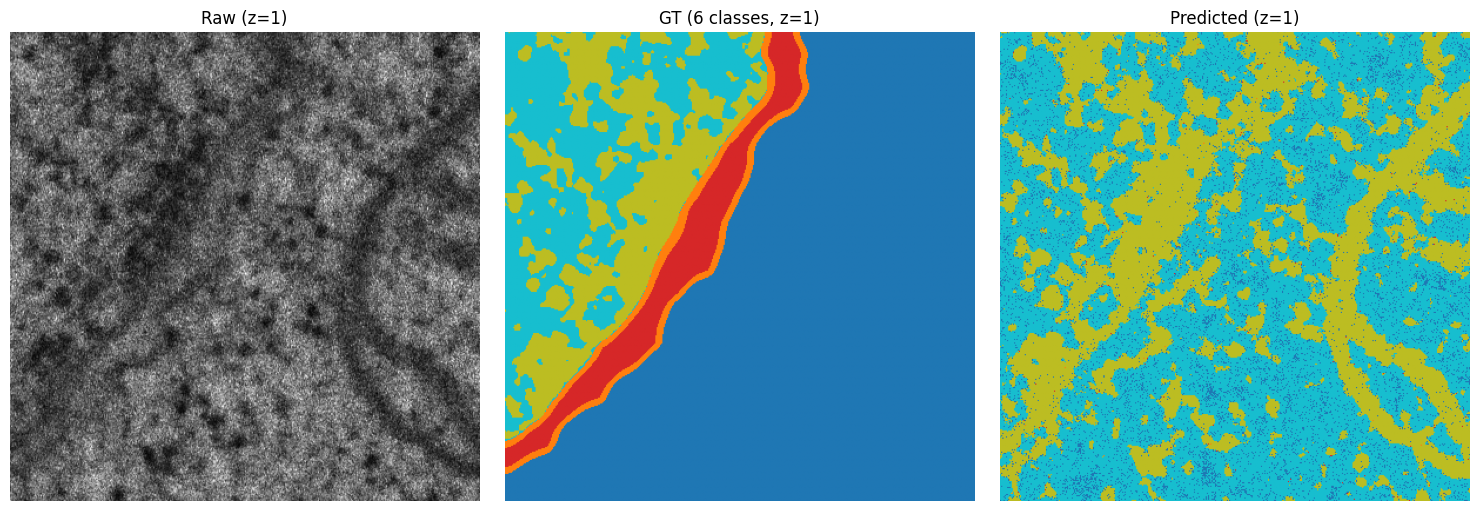

In [18]:
# ---------------------------------------------
# Test a specific z slice (predict + visualization)
# 测试某一层（z层）并可视化预测结果
# ---------------------------------------------

def test_one_slice(clf, raw_crop, label_multi, z):
    """
    测试单个 z-slice:
    - 提取 3D 特征
    - 调用 RF 做预测
    - 可视化 Raw / GT / Prediction
    """

    # ===== 1. 取该层的 raw + GT =====
    raw2d = raw_crop[z]
    label2d = label_multi[z]

    # ===== 2. 提取 3D 特征 =====
    feat = extract_3d_features(raw_crop, z)      # (400,400,C)
    X = feat.reshape(-1, feat.shape[-1])         # (160k, C)

    # ===== 3. RF 预测 =====
    y_pred_full = clf.predict(X).reshape(label2d.shape)

    # ===== 4. 可视化 =====
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(raw2d, cmap='gray')
    plt.title(f"Raw (z={z})")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(label2d, cmap='tab10')
    plt.title(f"GT (6 classes, z={z})")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(y_pred_full, cmap='tab10')
    plt.title(f"Predicted (z={z})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return y_pred_full

pred_image = test_one_slice(clf, raw_crop, label_multi, z=1)